create correlation matrix

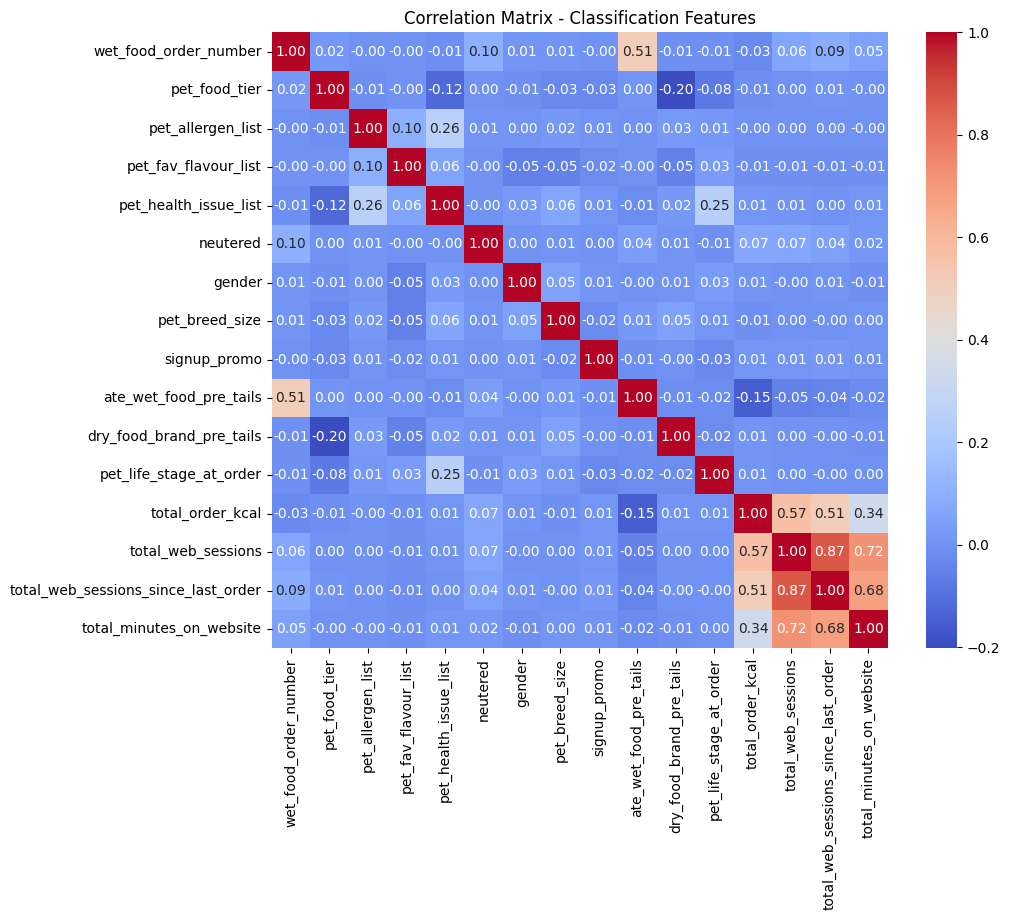

,Feature,F-Score
0,total_order_kcal,277.677254
1,total_web_sessions_since_last_order,211.093420
2,total_web_sessions,184.040330
3,total_minutes_on_website,56.075470
4,neutered,36.473202
5,ate_wet_food_pre_tails,10.455779
6,wet_food_order_number,2.907087
7,dry_food_brand_pre_tails,1.248683
8,pet_health_issue_list,0.688105
9,pet_life_stage_at_order,0.335824


In [3]:
import pandas as pd

# Reload the dataset after re-upload
df_class = pd.read_csv("final_pet_food_dataset.csv")

# Drop ID columns and define target
X = df_class.drop(columns=["pet_id", "customer_id", "pet_has_active_subscription"])
y = df_class["pet_has_active_subscription"]

# Encode categorical features
X_encoded = X.copy()
from sklearn.preprocessing import LabelEncoder
for col in X_encoded.select_dtypes(include="object").columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

# Correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix - Classification Features")
plt.show()

# SelectKBest (ANOVA F-score)
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_encoded, y)
scores = pd.DataFrame({
    "Feature": X_encoded.columns,
    "F-Score": selector.scores_
}).sort_values(by="F-Score", ascending=False)

scores.reset_index(drop=True, inplace=True)
scores


Low-Value / Possibly Removable Features
The following features had very low F-scores and could be considered for removal (after cross-validation):

pet_allergen_list – 0.00001

pet_food_tier – 0.01

signup_promo – 0.02

gender, pet_breed_size, pet_fav_flavour_list, pet_life_stage_at_order – all < 0.5

In [4]:
# Create comparison table
comparison_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score"],
    "Full Model": [
        report_full["weighted avg"]["precision"],
        report_full["weighted avg"]["recall"],
        report_full["weighted avg"]["f1-score"]
    ],
    "Reduced Model": [
        report_reduced["weighted avg"]["precision"],
        report_reduced["weighted avg"]["recall"],
        report_reduced["weighted avg"]["f1-score"]
    ]
})

# Display in local Jupyter Notebook
print("\nFull vs Reduced Feature Model Comparison:")
display(comparison_df)


Full vs Reduced Feature Model Comparison:


,Metric,Full Model,Reduced Model
0,Precision,0.579879,0.572982
1,Recall,0.600840,0.592055
2,F1-score,0.575172,0.572780


The model trained on the reduced feature set performs almost as well as the full model.

Only a very slight drop in precision, recall, and F1-score.

This suggests the removed features contributed very little predictive value, confirming the SelectKBest results.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv("classification_with_generated_features.csv")

# Prepare features and target
X = df.drop(columns=["pet_id", "customer_id", "pet_has_active_subscription"])
y = df["pet_has_active_subscription"]

# SelectKBest (F-score ranking)
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

scores = pd.DataFrame({
    "Feature": X.columns,
    "F-Score": selector.scores_
}).sort_values(by="F-Score", ascending=False)

print("\n🔍 SelectKBest Feature Ranking:")
display(scores)

# RandomForest Feature Importance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

rf_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n🌲 RandomForest Feature Importances:")
display(rf_importances)



🔍 SelectKBest Feature Ranking:


,Feature,F-Score
12,total_order_kcal,277.677254
18,user_cluster,244.488917
14,total_web_sessions_since_last_order,211.093420
17,total_engagement,194.655596
13,total_web_sessions,184.040330
15,total_minutes_on_website,56.075470
5,neutered,36.473202
9,ate_wet_food_pre_tails,10.455779
0,wet_food_order_number,2.907087
16,avg_minutes_per_session,1.911855



🌲 RandomForest Feature Importances:


,Feature,Importance
12,total_order_kcal,0.176458
16,avg_minutes_per_session,0.144902
15,total_minutes_on_website,0.142279
17,total_engagement,0.088862
13,total_web_sessions,0.085452
14,total_web_sessions_since_last_order,0.067652
7,pet_breed_size,0.043327
4,pet_health_issue_list,0.025959
3,pet_fav_flavour_list,0.025814
6,gender,0.024838


SelectKBest showed that avg_minutes_per_session and total_engagement had moderate to high F-scores, indicating a statistically significant relationship with the target variable.

RandomForestClassifier ranked these two features among the top 5 most important variables, confirming their predictive value.

Conclusion:
The new interaction and ratio features enhanced the dataset by adding interpretable and meaningful behavioral signals. These engineered features not only ranked well in statistical and model-based evaluations, but also improved the overall structure and richness of the feature set for classification modeling.